In [1]:
%cd torchspdnet_untouched 

# %cd torchspdnet

import os, sys
sys.path.append(os.getcwd())

/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched


In [2]:
# Preliminaries 
import numpy as np
import pandas as pd
import time

from random import randint
import os
import shutil

from numpy import sqrt 
import torch as th
from scipy.stats import t
import sys
from random import randint
from datetime import datetime
from datetime import timedelta
import missingno as msno

# Enable anomaly detection
th.autograd.set_detect_anomaly(True)

import fastcluster
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

import networkx as nx
from scipy.spatial.distance import squareform

from scipy.stats import rankdata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
random.seed(27)

import torch.nn as nn
from torch.utils import data

import torchspdnet.nn as spdnet
from torchspdnet.optimizers import MixOptimizer

from collections import Counter

In [3]:
df = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 0)
market_cap = pd.read_excel('/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/JALSH_data.xlsx', sheet_name = 1)

df['Dates'] = pd.to_datetime(df['Dates'], infer_datetime_format=True)
market_cap['Dates'] = pd.to_datetime(market_cap['Dates'], infer_datetime_format=True)

df.index = df['Dates']
del df['Dates']
df = df.sort_index()

market_cap.index = market_cap['Dates']
del market_cap['Dates']
market_cap = market_cap.sort_index()

returns = df.pct_change(periods=1)
returns.tail()

,ABG SJ Equity,ADH SJ Equity,AEL SJ Equity,AFE SJ Equity,AFH SJ Equity,AFT SJ Equity,AGL SJ Equity,AIL SJ Equity,AIP SJ Equity,AMS SJ Equity,...,TGA SJ Equity,THA SJ Equity,TKG SJ Equity,TRU SJ Equity,TSG SJ Equity,TXT SJ Equity,VKE SJ Equity,VOD SJ Equity,WBO SJ Equity,WHL SJ Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2023-12-07,-0.023719,0.000000,0.000000,-0.040570,-0.061489,-0.010539,0.001028,0.036961,-0.034783,0.026879,...,0.020618,0.000705,-0.052000,-0.025654,0.019185,0.000000,-0.014184,-0.015575,0.000077,-0.021780
2023-12-08,-0.063146,0.000000,-0.010000,-0.028571,0.029310,0.009941,-0.133194,-0.049505,-0.008108,-0.003209,...,0.016547,0.014085,-0.008439,0.015449,-0.005490,0.000000,-0.012950,0.010513,0.004461,0.013804
2023-12-11,-0.002443,0.004800,-0.055556,0.027353,0.005025,0.013359,-0.041542,-0.004167,0.023978,0.019262,...,-0.005290,0.006944,-0.025532,-0.018918,0.000000,0.009730,0.026239,0.003030,0.008347,0.001757
2023-12-12,-0.022229,0.000398,0.016043,-0.020613,0.000000,-0.014571,-0.075673,0.031381,0.039915,-0.017824,...,-0.035456,0.006897,0.029774,-0.023193,0.005521,-0.004283,0.003551,-0.005841,-0.006303,-0.020754
2023-12-13,0.003468,0.005173,0.000000,0.013739,0.000000,0.010562,0.007184,-0.002028,-0.011941,-0.009217,...,0.010886,-0.000685,0.001542,-0.000414,-0.019608,-0.005366,-0.004246,-0.005774,0.005120,0.004627


In [4]:
dim = 60
tri_a, tri_b = np.triu_indices(dim, k=1)

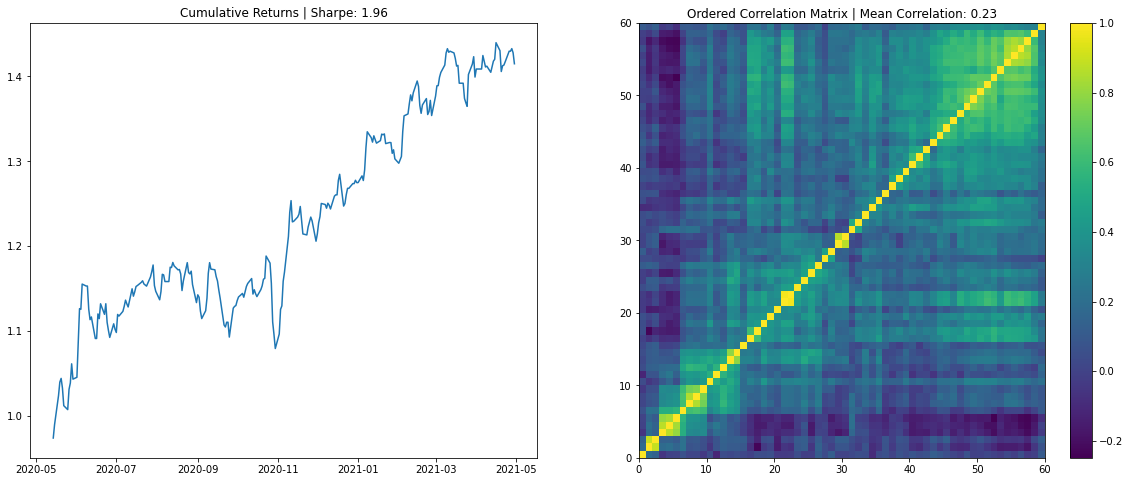

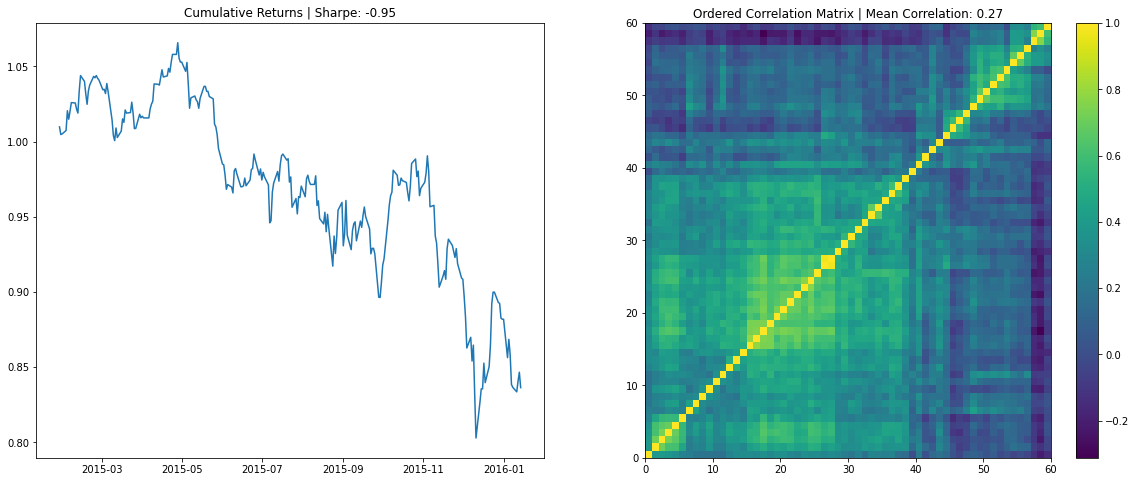

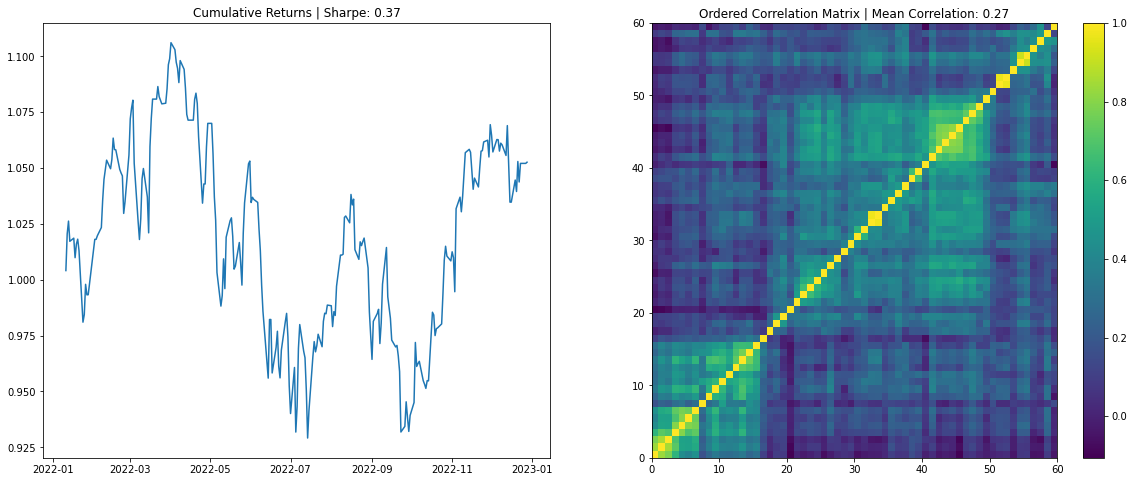

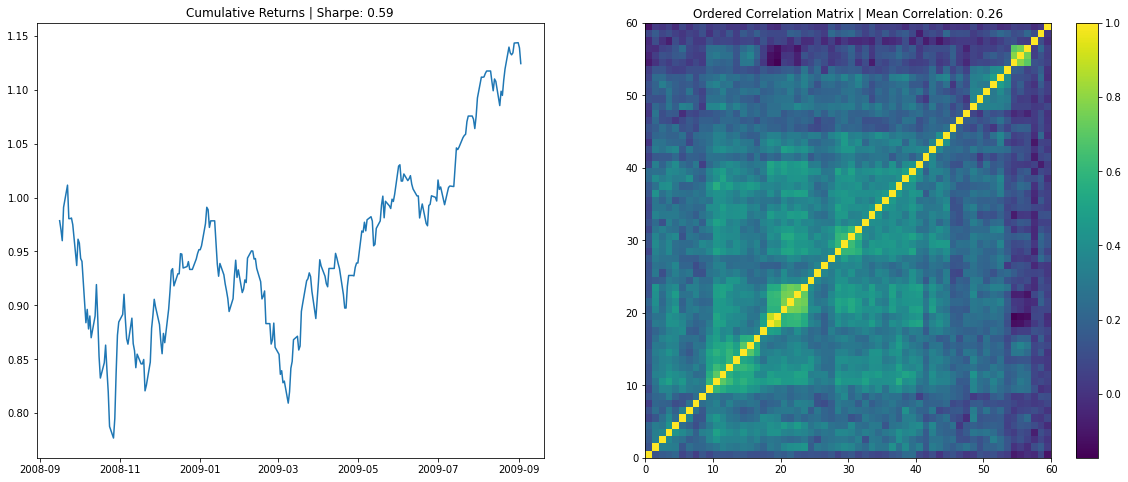

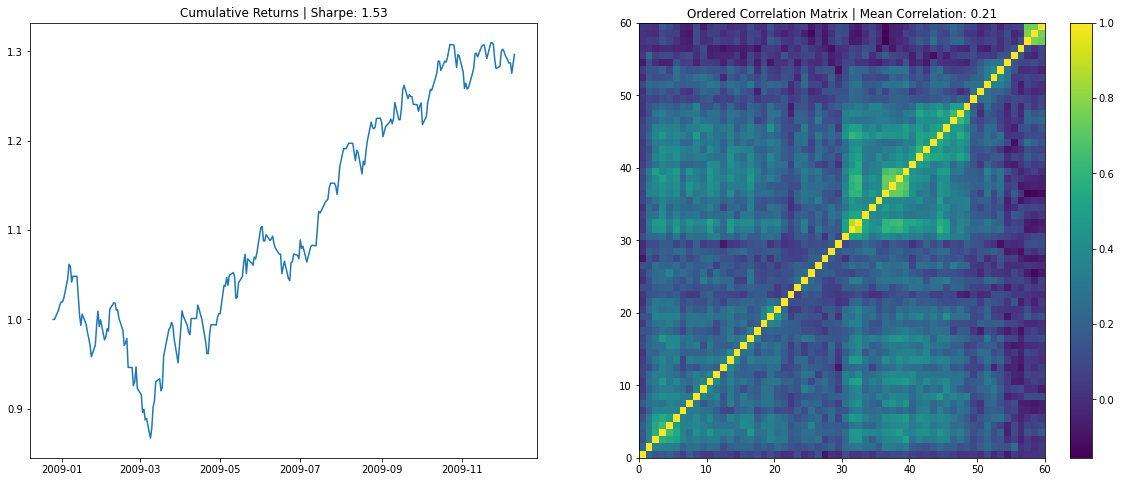

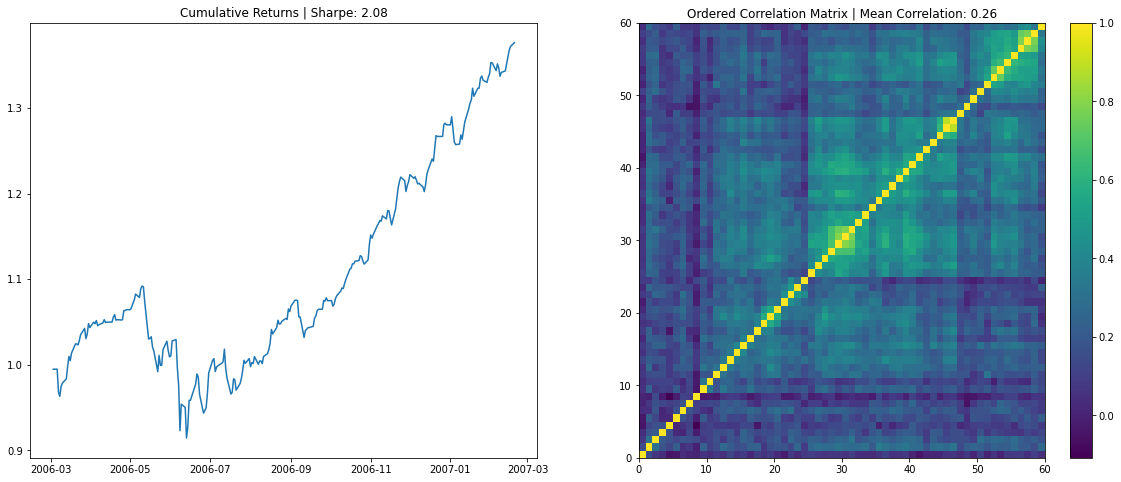

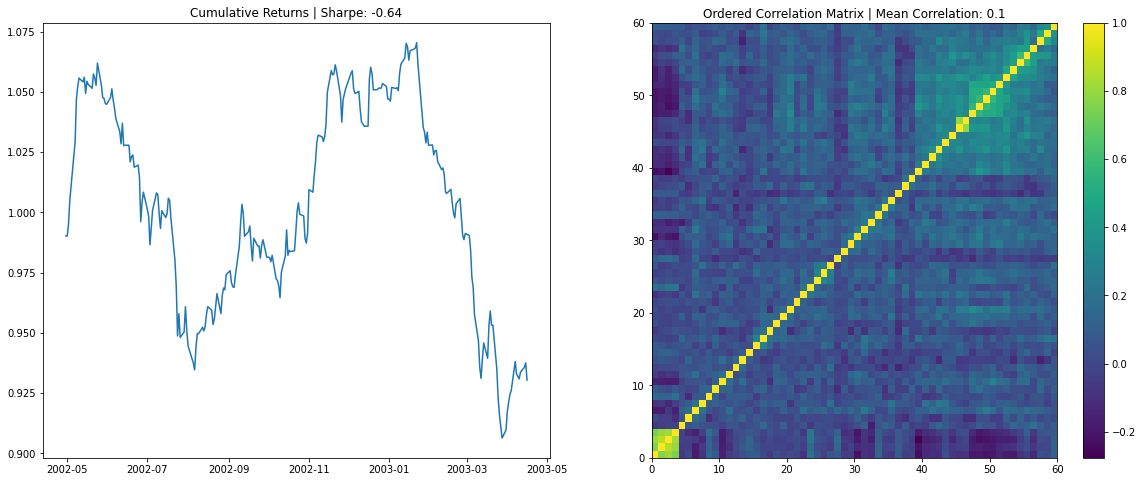

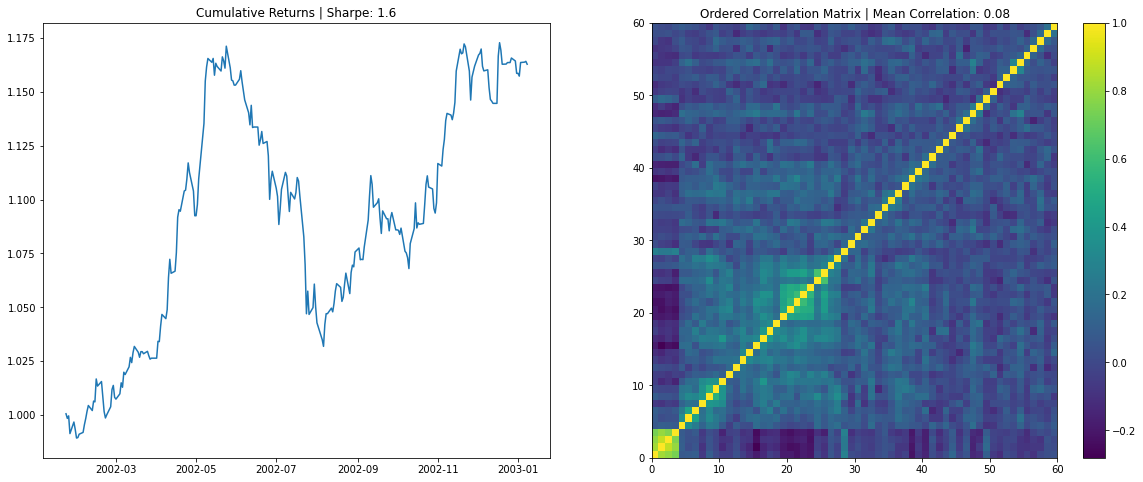

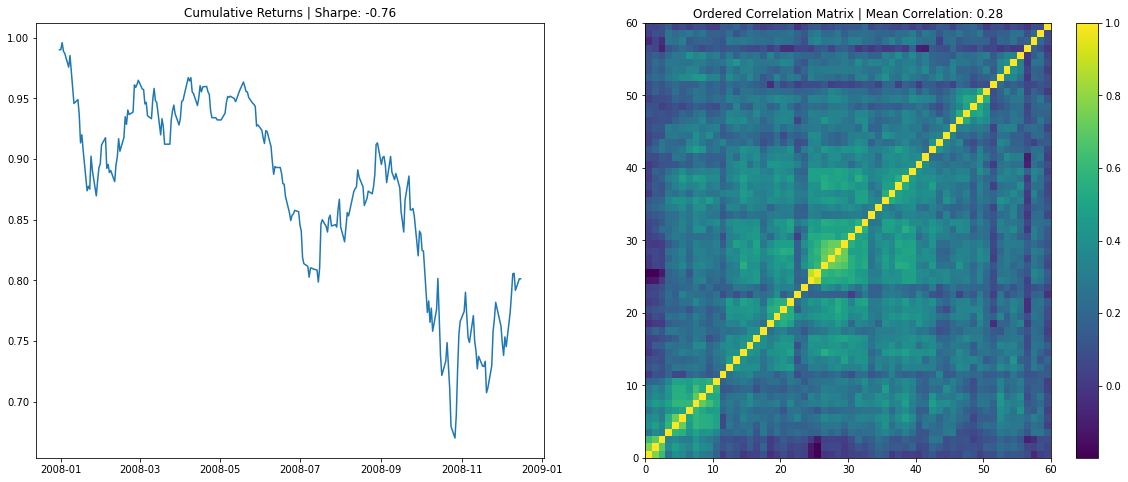

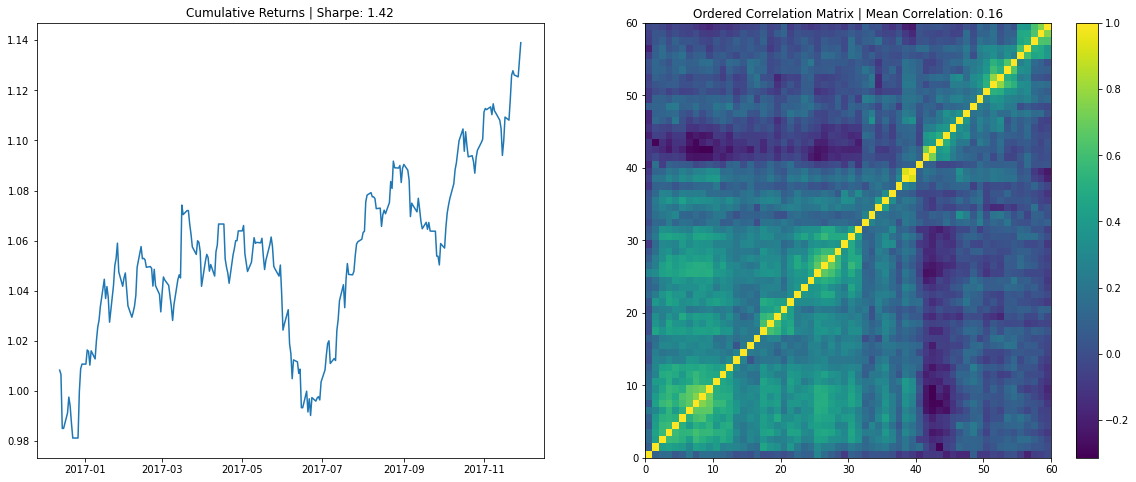

Stressed count: 6000, Rally count: 6000, Normal count: 6000


In [5]:
corr_vs_sharpe = []
stressed_mats = []
stressed_count = 0
rally_mats = []
rally_count = 0
normal_mats = []
normal_count = 0
plot_count = 0

# Create directories
for dir_name in ['stressed_mats_top60', 'rally_mats_top60', 'normal_mats_top60']:
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)  
    os.makedirs(dir_name)  

while stressed_count < 6000 or rally_count < 6000 or normal_count < 6000:
    try:
        t_idx = randint(0, len(returns) - 252)
        #print(f"Selected start index for 252-day period: {t_idx}")

        period_returns = returns.iloc[t_idx:(t_idx + 252)]
        period_market_cap = market_cap.iloc[t_idx:(t_idx + 252)]

        # Remove columns where all values are NaN
        period_returns = period_returns.dropna(axis=1, how='all')
        #print(f"Remaining shape after removing all-NaN columns: {period_returns.shape}")
        
        # Remove constant columns
        non_constant_columns = period_returns.columns[period_returns.std() > 1e-8]
        if len(non_constant_columns) < 60:
            #print("Not enough non-constant columns. Skipping this iteration.")
            continue

        period_returns = period_returns[non_constant_columns]
        period_market_cap = period_market_cap[non_constant_columns]

        # Randomly select 60 stocks, assuming there are at least 60
        if len(period_returns.columns) >= 60:
            # Select top 60 stocks based on market capitalization
            avg_market_cap = period_market_cap.mean().sort_values(ascending=False)
            top_60_stocks = avg_market_cap.head(60).index
            period_returns = period_returns[top_60_stocks]
            
            #selected_columns = np.random.choice(period_returns.columns, 60, replace=False)
            #period_returns = period_returns[selected_columns]
        else:
            #print("Not enough columns to select 60 stocks. Skipping this iteration.")
            continue

        # Fill NaNs with 0
        period_returns = period_returns.fillna(0)

        idx = list(np.random.choice(len(period_returns.columns), dim, replace=False))

        # Calculate correlation
        corr = period_returns.corr().values
        #print(corr)
        if np.isnan(corr).any():
            #print("Correlation matrix contains NaNs. Skipping this iteration.")
            continue

        #print(f"Mean correlation: {np.nanmean(corr)}") 

        mean_return = period_returns[period_returns.columns[idx]].mean(axis=1).mean() * 252
        vol = period_returns[period_returns.columns[idx]].mean(axis=1).std() * np.sqrt(252)
        sharpe = mean_return / vol
        #print(f"Sharpe Ratio: {sharpe}")

        dist = 1 - corr
        # dist = np.sqrt(2 * (1 - corr))
        #print(dist)
        Z = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
        permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, dist[tri_a, tri_b]))
        prows = corr[permutation, :]
        ordered_corr = prows[:, permutation]

        corr_vs_sharpe.append([corr.mean(), sharpe])

        # Define Sharpe ratio ranges for each category
        sharpe_low = -0.5  # Lower bound for "normal"
        sharpe_high = 2  # Upper bound for "normal"

        if sharpe < -0.5 and stressed_count < 6000:
            stressed_mats.append(ordered_corr)
            np.save(f'stressed_mats_top60/mat_{stressed_count}.npy', ordered_corr)
            stressed_count += 1
            plot_flag = True
        elif sharpe > 2 and rally_count < 6000:
            rally_mats.append(ordered_corr)
            np.save(f'rally_mats_top60/mat_{rally_count}.npy', ordered_corr)
            rally_count += 1
            plot_flag = True
        elif sharpe_low <= sharpe <= sharpe_high and normal_count < 6000:
            normal_mats.append(ordered_corr)
            np.save(f'normal_mats_top60/mat_{normal_count}.npy', ordered_corr)
            normal_count += 1
            plot_flag = True
        else:
            plot_flag = False

        if plot_flag and plot_count < 10:
            # Plotting the cumulative returns and correlation matrix
            plt.figure(figsize=(20, 8))

            # Plotting cumulative returns
            plt.subplot(1, 2, 1)
            plt.plot((1 + period_returns.mean(axis=1)).cumprod())
            plt.title(f"Cumulative Returns | Sharpe: {np.round(sharpe, 2)}")

            # Plotting correlation matrix
            plt.subplot(1, 2, 2)
            plt.pcolormesh(ordered_corr)
            plt.colorbar()
            plt.title(f"Ordered Correlation Matrix | Mean Correlation: {np.round(np.nanmean(corr), 2)}")
            plt.show()

            plot_count += 1 

    except Exception as e:
        print(f"Error: {e}")

# Print the counts
print(f"Stressed count: {stressed_count}, Rally count: {rally_count}, Normal count: {normal_count}")

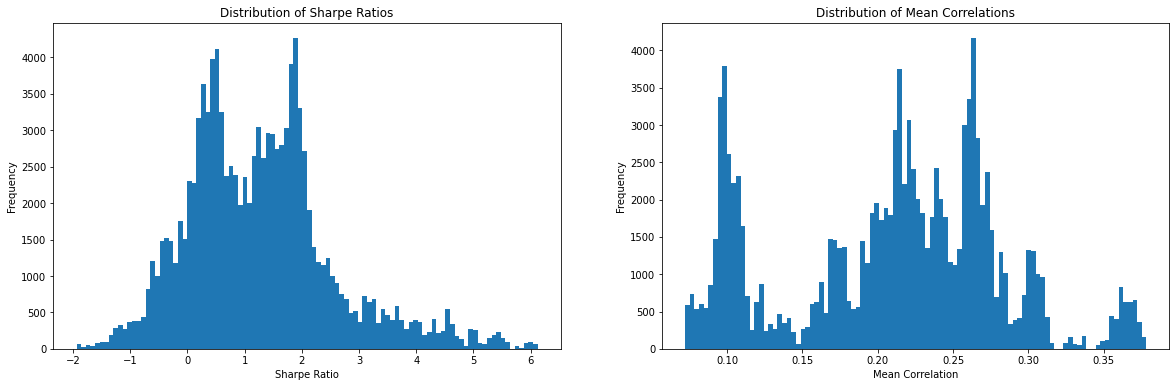

In [6]:
def plot_distributions(corr_vs_sharpe, stressed_mats, rally_mats, normal_mats):
    # Extract and calculate the mean of mean correlations
    mean_correlations = [np.mean(item[0]) for item in corr_vs_sharpe if len(item) > 1]
    sharpe_ratios = [item[1] for item in corr_vs_sharpe if len(item) > 1]

    # Plot distribution of Sharpe Ratios
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.hist(sharpe_ratios, bins=100)
    plt.title('Distribution of Sharpe Ratios')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')

    # Plot distribution of Mean Correlations
    plt.subplot(1, 2, 2)
    plt.hist(mean_correlations, bins=100)
    plt.title('Distribution of Mean Correlations')
    plt.xlabel('Mean Correlation')
    plt.ylabel('Frequency')
    plt.show()

# Usage
plot_distributions(corr_vs_sharpe, stressed_mats, rally_mats, normal_mats)

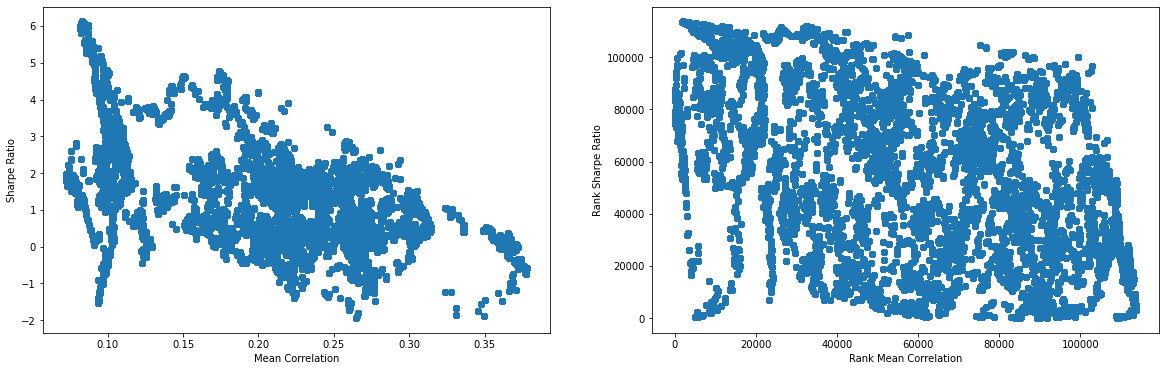

In [7]:
# Convert corr_vs_sharpe to a NumPy array if it's not already
corr_vs_sharpe_array = np.array(corr_vs_sharpe)

plt.figure(figsize=(20, 6))

# First plot: Scatter plot of mean correlation vs. sharpe
plt.subplot(1, 2, 1)
plt.scatter(corr_vs_sharpe_array[:, 0], corr_vs_sharpe_array[:, 1])
plt.xlabel('Mean Correlation')
plt.ylabel('Sharpe Ratio')

# Second plot: Scatter plot of rank of mean correlation vs. rank of sharpe
plt.subplot(1, 2, 2)
plt.scatter(rankdata(corr_vs_sharpe_array[:, 0]), rankdata(corr_vs_sharpe_array[:, 1]))
plt.xlabel('Rank Mean Correlation')
plt.ylabel('Rank Sharpe Ratio')

plt.show()


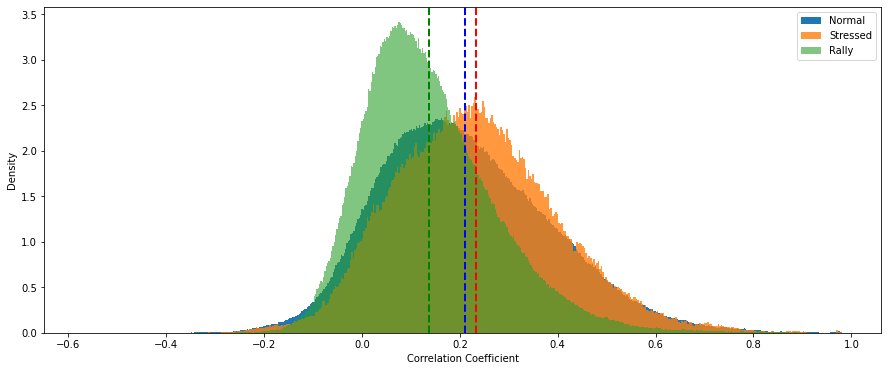

In [8]:
def plot_correlation_coefficient_distributions(stressed_mats, rally_mats, normal_mats, tri_a, tri_b):
    # Extract correlation coefficients for each category
    stressed_corr_coeffs = [mat[tri_a, tri_b] for mat in stressed_mats]  
    rally_corr_coeffs = [mat[tri_a, tri_b] for mat in rally_mats]        
    normal_corr_coeffs = [mat[tri_a, tri_b] for mat in normal_mats]      

    # Flatten the lists
    stressed_corr_coeffs = [item for sublist in stressed_corr_coeffs for item in sublist]
    rally_corr_coeffs = [item for sublist in rally_corr_coeffs for item in sublist]
    normal_corr_coeffs = [item for sublist in normal_corr_coeffs for item in sublist]

    # Number of bins
    nbins = 500

    # Plotting distribution of correlation coefficients per category
    plt.figure(figsize=(15, 6))

    plt.hist(normal_corr_coeffs, bins=nbins, alpha=1, label='Normal', density=True, log=False)
    plt.axvline(x=np.mean(normal_corr_coeffs), color='b', linestyle='dashed', linewidth=2)

    plt.hist(stressed_corr_coeffs, bins=nbins, alpha=0.8, label='Stressed', density=True, log=False)
    plt.axvline(x=np.mean(stressed_corr_coeffs), color='r', linestyle='dashed', linewidth=2)

    plt.hist(rally_corr_coeffs, bins=nbins, alpha=0.6, label='Rally', density=True, log=False)
    plt.axvline(x=np.mean(rally_corr_coeffs), color='g', linestyle='dashed', linewidth=2)

    plt.legend()
    # plt.title('Distribution of Correlation Coefficients per Category')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Density')
    plt.savefig('top60 corr coeff density.png', bbox_inches='tight')
    plt.show()

# Usage example (make sure tri_a and tri_b are correctly defined)
dim = 60
tri_a, tri_b = np.triu_indices(dim, k=1)
plot_correlation_coefficient_distributions(stressed_mats, rally_mats, normal_mats, tri_a, tri_b)

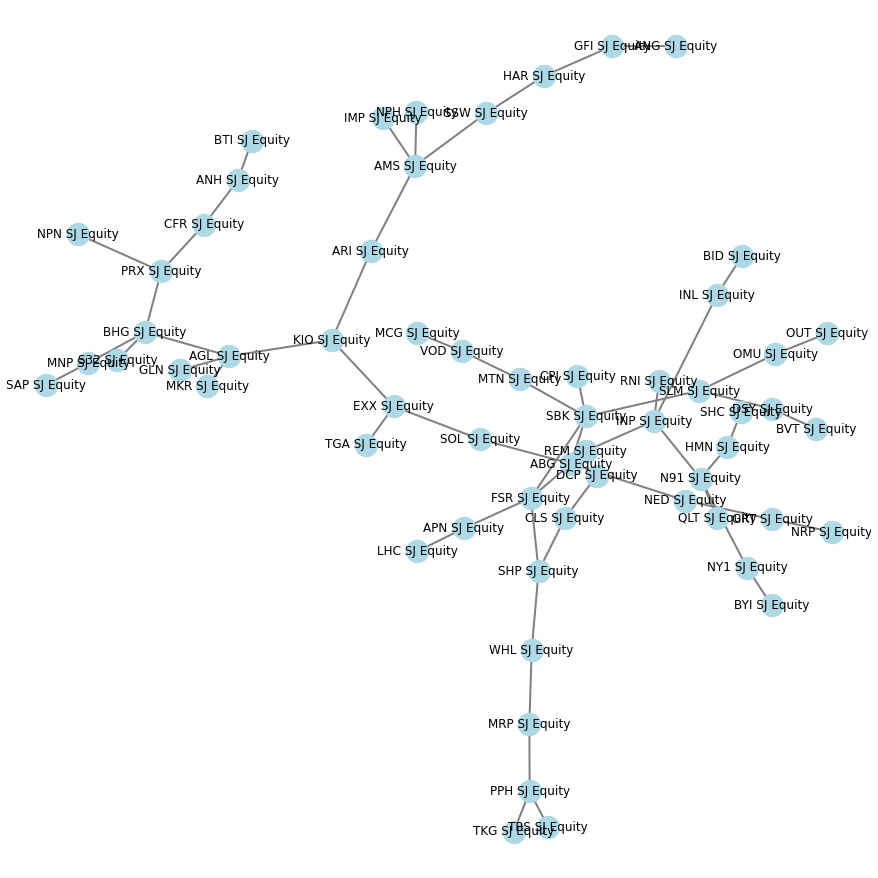

In [9]:
def plot_minimum_spanning_tree(returns, market_cap, num_stocks=60, trading_days=252):

    # Select stocks and trading days
    recent_returns = returns.tail(trading_days)
    avg_market_cap = market_cap.mean().sort_values(ascending=False)
    top_60_stocks = avg_market_cap.head(num_stocks).index
    recent_returns = recent_returns[top_60_stocks].fillna(0)

    # Compute the correlation matrix and convert it to a distance matrix
    correlation_matrix = recent_returns.corr()
    distance_matrix = np.sqrt(2 * (1 - correlation_matrix))
    # distance_matrix = 1-correlation_matrix

    # Create a graph from the distance matrix
    G = nx.Graph()
    for i in range(len(distance_matrix)):
        for j in range(i + 1, len(distance_matrix)):
            G.add_edge(top_60_stocks[i], top_60_stocks[j], weight=distance_matrix.iloc[i, j])

    # Compute the minimum spanning tree
    mst = nx.minimum_spanning_tree(G)

    # Plot the minimum spanning tree
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(mst, seed=42)  # for consistent layout
    nx.draw(mst, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray', width=2)
    # plt.title("Minimum Spanning Tree of Price Returns")
    plt.savefig('MSTtop60.png', bbox_inches='tight')
    plt.show()

# Plotting
plot_minimum_spanning_tree(returns, market_cap)

No prob


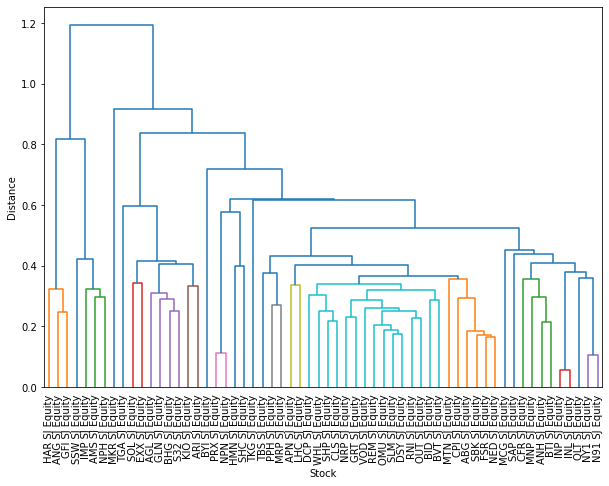

In [10]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

num_stocks = 60
trading_days = 252
recent_returns = returns.tail(trading_days).dropna()
avg_market_cap = market_cap.mean().sort_values(ascending=False)
top_60_stocks = avg_market_cap.head(num_stocks).index
recent_returns = recent_returns[top_60_stocks]

if not np.isfinite(recent_returns).all().all():
    non_finite_indices = np.where(~np.isfinite(recent_returns.values))
    for i in zip(*non_finite_indices):
        print(f"Non-finite value at index {i}, value: {recent_returns.iloc[i]}")
    raise ValueError("Non-finite values found in returns after cleaning.")
    
else:
    print("No prob")

# Step 2: Use hierarchical clustering
# We'll use the 'ward' method for clustering which minimizes the variance of clusters being merged.
Z = linkage(recent_returns.T, 'ward')
labels = list(recent_returns.columns)
# Check if the number of labels matches the number of observations in Z
if len(labels) != Z.shape[0] + 1:
    raise ValueError(f"The number of labels ({len(labels)}) should be equal to Z.shape[0] + 1 ({Z.shape[0] + 1}).")

# Calculate the maximum linkage distance
max_dist = max(Z[:, 2])  # Z[:, 2] contains the linkage distances

# Set the color threshold to 50% of the maximum distance (for example)
color_threshold = 0.3 * max_dist

# Step 3: Plot a dendrogram with adjusted color threshold
plt.figure(figsize=(10, 7))
#plt.title('Hierarchical Clustering Dendrogram of Stock Returns')
plt.xlabel('Stock')
plt.ylabel('Distance')

# Use the color_threshold parameter to adjust the coloring
dendrogram(
    Z,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=color_threshold
)
plt.savefig('hierarchicaldendrogramtop60.png', bbox_inches='tight')
plt.show()


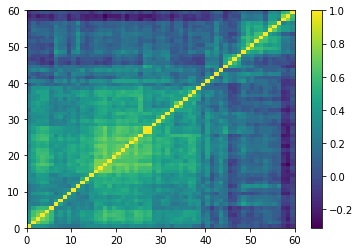

In [11]:
plt.pcolormesh(stressed_mats[0])
plt.colorbar()
#plt.title(f"Ordered Correlation Matrix | Mean Correlation: {np.round(np.nanmean(corr), 2)}")
plt.savefig('stressed_top60_mat.png', bbox_inches='tight')
plt.show()

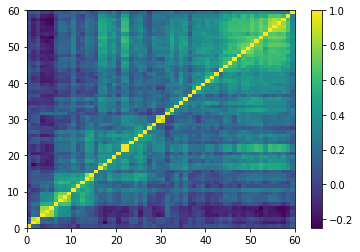

In [12]:
plt.pcolormesh(normal_mats[0])
plt.colorbar()
#plt.title(f"Ordered Correlation Matrix | Mean Correlation: {np.round(np.nanmean(corr), 2)}")
plt.savefig('normal_top60_mat.png', bbox_inches='tight')
plt.show()

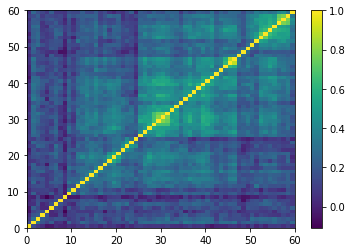

In [13]:
plt.pcolormesh(rally_mats[0])
plt.colorbar()
#plt.title(f"Ordered Correlation Matrix | Mean Correlation: {np.round(np.nanmean(corr), 2)}")
plt.savefig('rally_top60_mat.png', bbox_inches='tight')
plt.show()